In [1]:
# Import packages
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [3]:
# GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # First GCN layer: input features -> 16 hidden features
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        # Second GCN layer: 16 hidden features -> output classes
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GCN layer + ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Apply second GCN layer
        x = self.conv2(x, edge_index)

        # Apply log_softmax for NLLLoss
        return F.log_softmax(x, dim=1)

    def embed(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x

In [4]:
device = torch.device("mps")
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [5]:
# Model training
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # Use only the training nodes for loss calculation
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()

Epoch 0, Loss: 1.9429739713668823
Epoch 1, Loss: 1.8458688259124756
Epoch 2, Loss: 1.7412943840026855
Epoch 3, Loss: 1.6089714765548706
Epoch 4, Loss: 1.4805656671524048
Epoch 5, Loss: 1.363226294517517
Epoch 6, Loss: 1.2552632093429565
Epoch 7, Loss: 1.1621313095092773
Epoch 8, Loss: 1.0454349517822266
Epoch 9, Loss: 0.9594259858131409
Epoch 10, Loss: 0.8575369715690613
Epoch 11, Loss: 0.8257491588592529
Epoch 12, Loss: 0.6964924931526184
Epoch 13, Loss: 0.6120434403419495
Epoch 14, Loss: 0.5638885498046875
Epoch 15, Loss: 0.500697910785675
Epoch 16, Loss: 0.4021635353565216
Epoch 17, Loss: 0.37969768047332764
Epoch 18, Loss: 0.36832699179649353
Epoch 19, Loss: 0.3202451169490814
Epoch 20, Loss: 0.28635773062705994
Epoch 21, Loss: 0.26184025406837463
Epoch 22, Loss: 0.2287682145833969
Epoch 23, Loss: 0.19609366357326508
Epoch 24, Loss: 0.2057972550392151
Epoch 25, Loss: 0.2128429412841797
Epoch 26, Loss: 0.13737116754055023
Epoch 27, Loss: 0.12761655449867249
Epoch 28, Loss: 0.1573229

In [6]:
model.eval()
pred = model(data).argmax(dim=1)
# test accuracy
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Classification Accuracy: {acc:.4f}')

Classification Accuracy: 0.8010


In [7]:
# Use networkX
g = nx.Graph()
g.add_nodes_from(range(data.num_nodes))
edges = data.edge_index.t().tolist()
g.add_edges_from(edges)

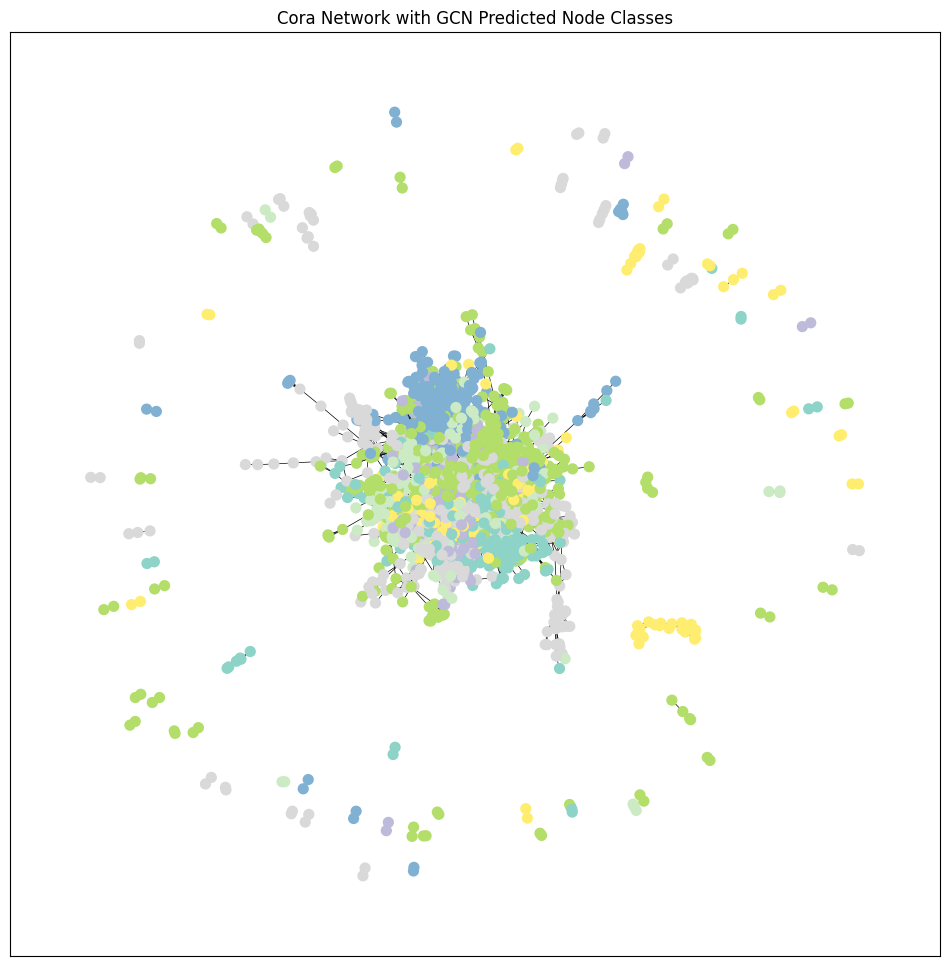

In [8]:
node_colors = [pred[i].item() for i in range(data.num_nodes)]

plt.figure(figsize=(12, 12))
nx.draw_networkx(g,
                 pos=nx.spring_layout(g, seed=42), # for consistent layout
                 with_labels=False,
                 node_size=50,
                 node_color=node_colors,
                 cmap="Set3", # color map for classes
                 width=0.5)
plt.title("Cora Network with GCN Predicted Node Classes")
plt.show()

In [12]:
with torch.no_grad():
    embeddings = model.embed(data).detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
pos_2d = tsne.fit_transform(embeddings)
pos = {i: pos_2d[i] for i in range(data.num_nodes)}

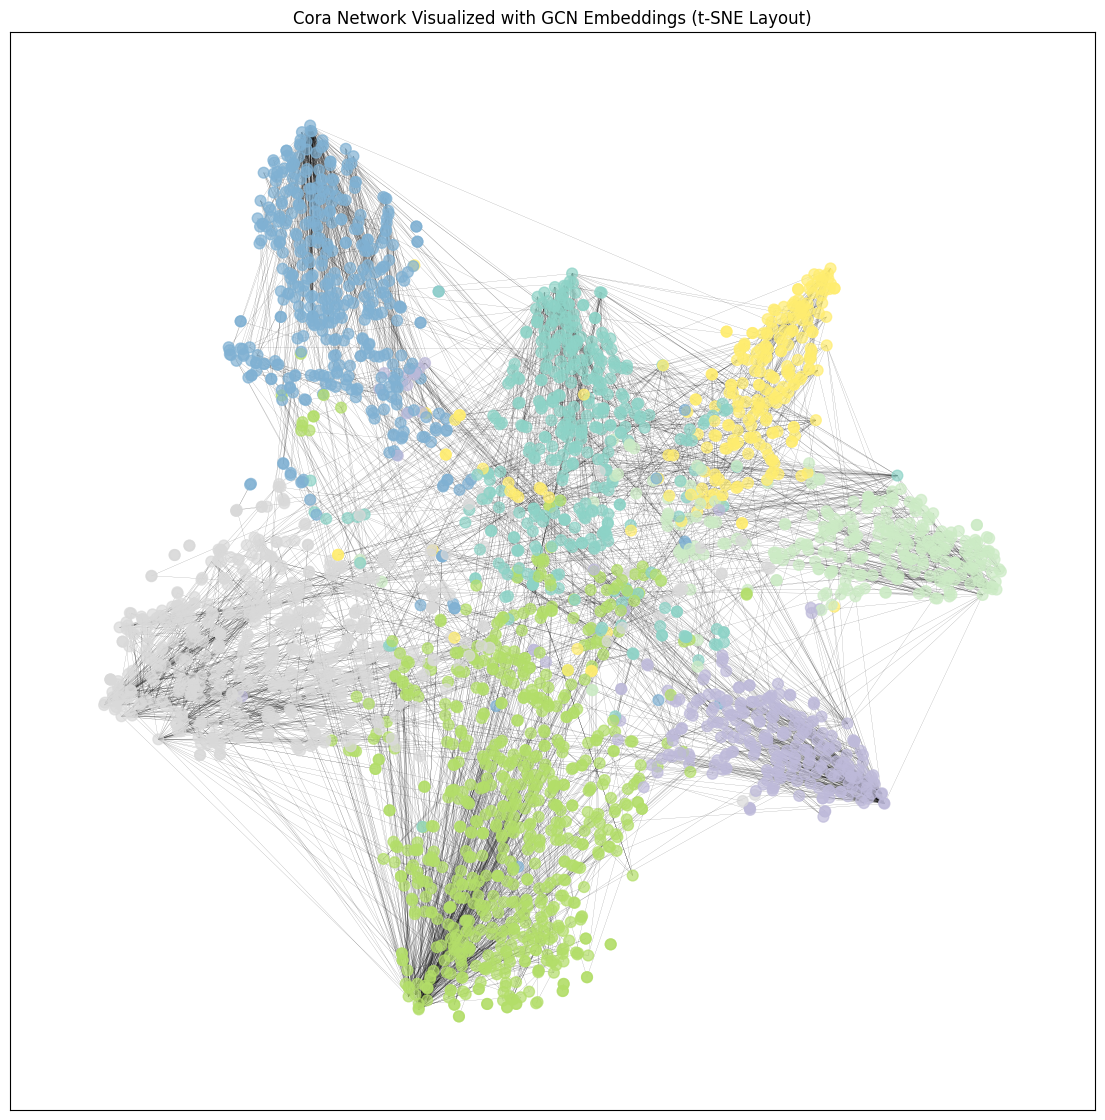

In [13]:
g = nx.Graph()
g.add_nodes_from(range(data.num_nodes))
edges = data.edge_index.cpu().t().tolist()
g.add_edges_from(edges)

node_colors = [pred.cpu()[i].item() for i in range(data.num_nodes)]

plt.figure(figsize=(14, 14))
nx.draw_networkx(g,
                 pos=pos, # Use the new t-SNE positions!
                 with_labels=False,
                 node_size=60,
                 node_color=node_colors,
                 cmap="Set3",
                 width=0.1, # Make edges thinner to see nodes better
                 alpha=0.7)
plt.title("Cora Network Visualized with GCN Embeddings (t-SNE Layout)")
plt.show()

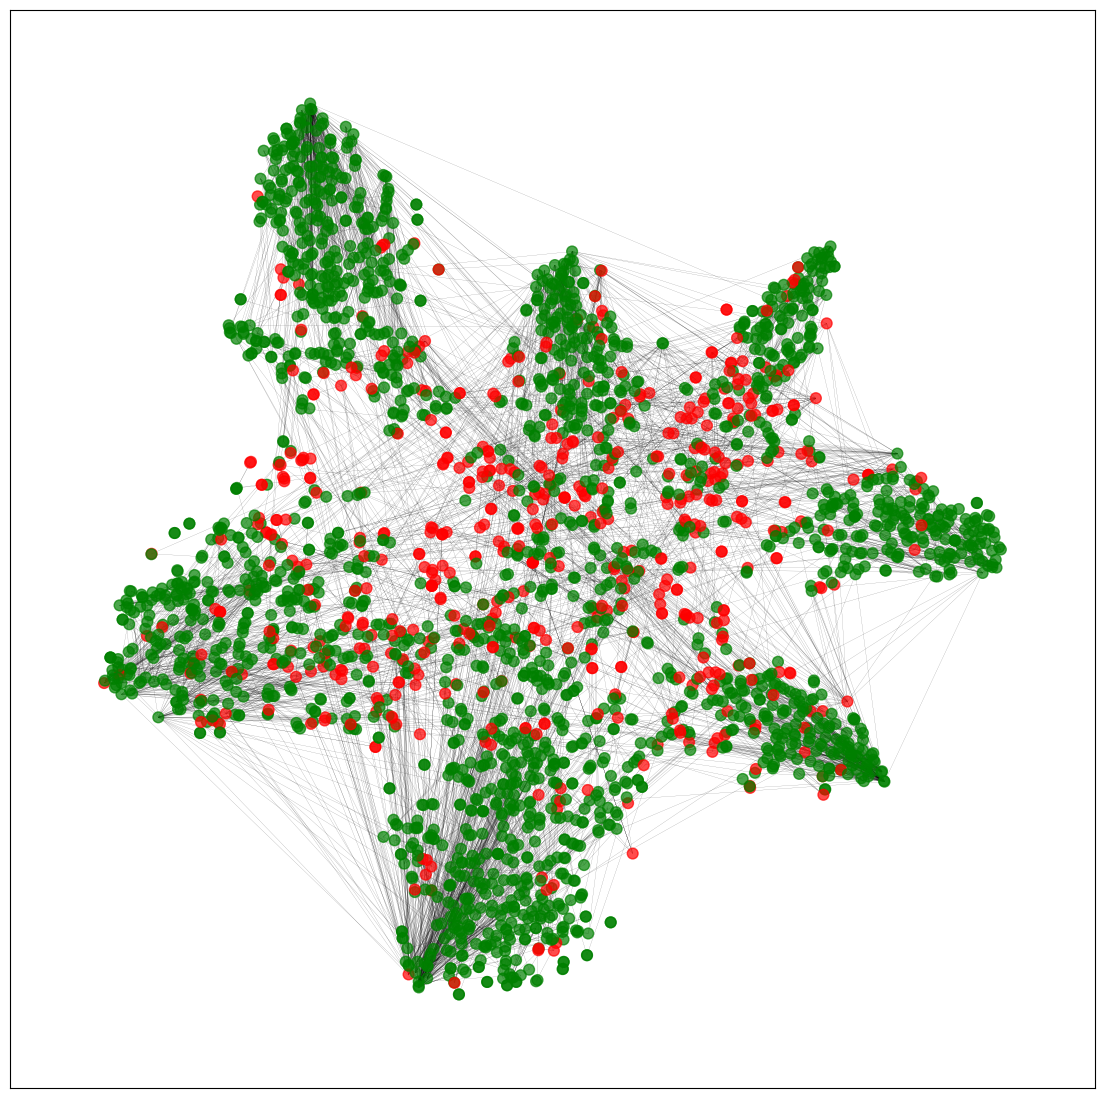

In [14]:
true_labels = data.y.cpu()
predictions = pred.cpu()

node_colors = []
for i in range(data.num_nodes):
    if predictions[i] == true_labels[i]:
        node_colors.append('green') # Correct prediction
    else:
        node_colors.append('red')   # Incorrect prediction

plt.figure(figsize=(14, 14))
nx.draw_networkx(g,
                 pos=pos,
                 with_labels=False,
                 node_size=60,
                 node_color=node_colors, # Use the new green/red color list
                 # cmap is no longer needed since we provide explicit colors
                 width=0.1,
                 alpha=0.7)